
Cases from Zhong (2000):
- Case 1: ml.viscosity = 1e22 * u.pascal * u.second, ma.viscosity = 1e21 * u.pascal * u.second
- Case 2: ml.viscosity = 1e23 * u.pascal * u.second, ma.viscosity = 1e21 * u.pascal * u.second 
- Case 3: ml.viscosity = 1e24 * u.pascal * u.second, ma.viscosity = 1e21 * u.pascal * u.second 
- Case 4: include a weak lower crust


In [1]:
import numpy as np
import math
import mpmath as mp
mp.mp.dps = 100  
#sometime get error when dps = 100
#mp.mp.dps = 94
import cmath
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.fft import dct, idct

### Constant

In [2]:
# scaling
# delta_rho=500
# densitym = 3300.0
# densityc = 6600.0
pi = mp.pi
visc0 = 1e21
amu = 1.5e11
akapa=1e-6
d=3.0e6
g=10.0
zero=0.0
one=1.0
two = 2.0
three = 3.0
pt33 = one/three
pt66 = two/three
year = 365.0*24*3600.0
twopig = 2.0*pi*6.6732e-11
bemillga = 1.0e05
gi = g

# zsi=0.0
# ami=40.0
# ali=100.0

### input for test:

In [3]:
case_name = "testx_Case1ForVelBc_"

# [kg/m^3] density contrast, mantle density, core density, [m] whole mantle (box) thickness for scaling
delta_rhoi,densitymi,densityci,ddi,dti = 500,3300,6600,3e6,8e7
wavelengthi,ali,al1i,ami,am1i,dmoho,dsurf =300,100,55,35,20,-0.0,0.0
zsi,dTempi = 200,0.0
# viscosity[Pa.s] 

visci = mp.matrix([1e21,1e22,1e22,1e22,1e22])  # case1

#visci = mp.matrix([1e21,1e23,1e23,1e23,1e23])  # case2

#visci = mp.matrix([1e21,1e24,1e24,1e24,1e24])  # case3


# [pascal] shear modulus
amui= 1.5e11
iv_or_t,v_or_t,boxl,all1,ramp1,all0,ramp0 =1,-1.5,4000.0,0.0,500.0,3500.0,500.0
#iv_or_t,v_or_t,boxl,all1,ramp1,all0,ramp0 =1,-1.5,6000.0,0.0,500.0,5500.0,500.0
#iv_or_t,v_or_t,boxl,all1,ramp1,all0,ramp0 =1,1.5,6000.0,0.0,0.0,5500.0,500.0
# total of harmonics, total of points
iso,kkt,nox = 0,200,201
# [year] the time for output
#ft =  mp.matrix([1e4,1e5,1e6,2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6,10e6,11e6,12e6,13e6,14e6,15e6,17e6,20e6,23e6,28e6,35e6,55e6,77e6])
ft =  mp.matrix([0,2.5e5,5e5])
ntime = ft.rows

In [4]:
xcoordi = np.linspace(-boxl*1000/2,boxl*1000/2,nox) 

if iso == 1:
    if dmoho != 0.0:
        dsurf = mp.mpf(-dmoho*delta_rhoi/(densitymi-delta_rhoi))
    elif dsurf != 0.0:
        dmoho =  mp.mpf(-dsurf*(densitymi-delta_rhoi)/delta_rhoi)
        
mantle_s = 0
dTempi = 0.0    
if abs(dTempi) > 0.0:
    mantle_s = 1        
        
d = mp.mpf(ddi)
delta_rho=mp.mpf(delta_rhoi)
densitym=mp.mpf(densitymi)
densityc=mp.mpf(densityci)
wavelength=mp.mpf(wavelengthi)
al=mp.mpf(ali)
al1=mp.mpf(al1i)
am=mp.mpf(ami)
am1=mp.mpf(am1i)

visc1i,visc2i,visc3i,visc4i,visc5i = visci
visc = visci

amu=mp.mpf(amui)
zs=mp.mpf(zsi)
dTemp=dTempi*1000/d

wavelength = wavelength*1000/d
al = one-al*1000/d
al1= one-al1*1000/d
am = one-am*1000/d
am1= one-am1*1000/d
zs = one-zs*1000/d

gama = densityc/densitym

tscaling = visc0/amu
vscaling = d/tscaling*100*year
sscaling = amu

qqq = -(1.0-gama)*densitym*g*d/amu
qqq1= -(densitym-delta_rho)*g*d/amu
r0  = densitym*g*d/amu

if iv_or_t==1:
    v_or_t = v_or_t/vscaling
else:
    v_or_t = v_or_t/sscaling
    
    
delta_rho = delta_rho/densitym
tau  = visc/(amu*tscaling)
visc1,visc2,visc3,visc4,visc5 = visc/visc0

topo_s = mp.matrix(ntime, nox)
topo_m = mp.matrix(ntime, nox)
topo_b = mp.matrix(ntime, nox)


f = mp.matrix(kkt,4)
for k in range(1, kkt+1):
#     wavelength1= 2*boxl*1000/k
#     wavelength = wavelength1/d
#     ak = 2*pi/wavelength
#     aki = 2*pi/wavelength1
    f[k-1,0] = dmoho*1000/d
    f[k-1,1] = dsurf*1000/d
    f[k-1,2] = 0
    
    if  ramp1 != 0.0:
        f[k-1,3] = v_or_t/(pi*k)* (mp.cos(pi*k*(ramp1+all1)/boxl)-\
                                   boxl/(ramp0*pi*k)* \
                               (mp.sin(pi*k*(ramp0+all0)/boxl)-mp.sin(pi*k*all0/boxl)) \
                               -mp.cos(pi*k*ramp1/boxl)+\
                                   boxl/(ramp1*pi*k)*mp.sin(pi*k*ramp1/boxl))
    else:
        f[k-1,3] = v_or_t/(pi*k)* \
              (mp.cos(pi*k*(ramp1+all1)/boxl)-boxl/(ramp0*pi*k)* \
            (mp.sin(pi*k*(ramp0+all0)/boxl)-mp.sin(pi*k*all0/boxl)) )

In [5]:
topo_v0_new = mp.matrix(nox,1)
for k in range(1, kkt+1):
    wavelength1 = 2 * boxl * 1000 / k
    aki = np.float128(2 * pi / wavelength1)
    for ij in range(nox):
        topo_v0_new[ij] += f[k-1,3] * mp.cos(xcoordi[ij] * aki)* vscaling

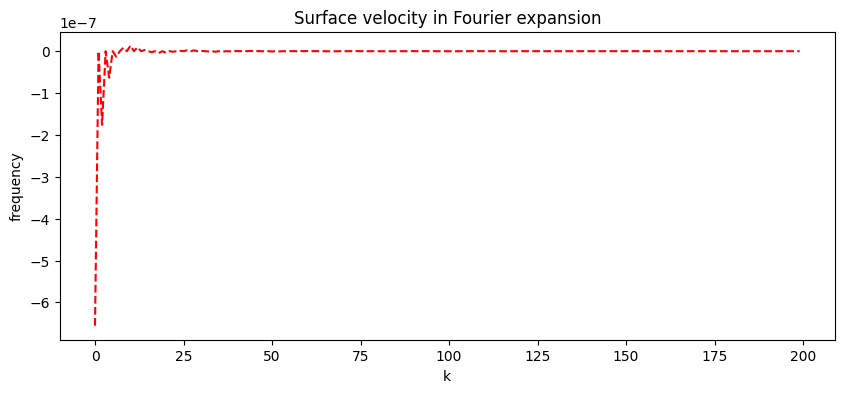

In [6]:
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='k', ylabel='frequency',title="Surface velocity in Fourier expansion") 
ax1.plot(f[:,3],"r--",label="Vel")


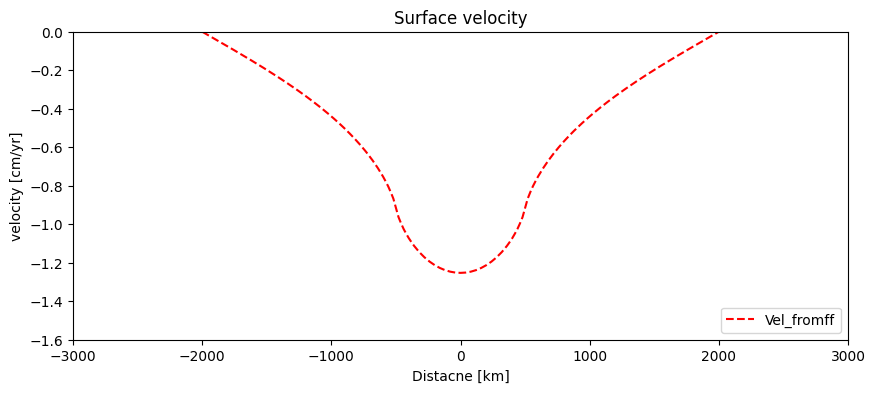

In [7]:
fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='Distacne [km]', ylabel='velocity [cm/yr]',title='Surface velocity') 
ax1.set_xlim([-3000,3000])
ax1.set_ylim([-1.6,0])
#ax1.plot(xcoordi/1000,topo_v0[:]*100,c="k",label="Vel_origin")
ax1.plot(xcoordi/1000,topo_v0_new[:],"r--",label="Vel_fromff")
ax1.legend(loc='lower right')
fig.savefig(case_name+"vel_inx")

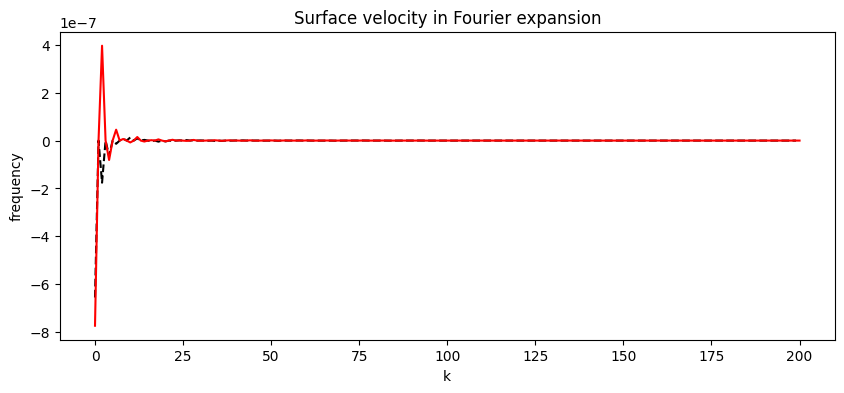

In [8]:
type_ = 1
yr = idct(np.float128(topo_v0_new/vscaling)*2,type=type_,n=kkt+1)

fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='k', ylabel='frequency',title="Surface velocity in Fourier expansion") 
ax1.plot(f[:,3],"k--",label="Vel")
ax1.plot(yr,"r-",label="Vel")

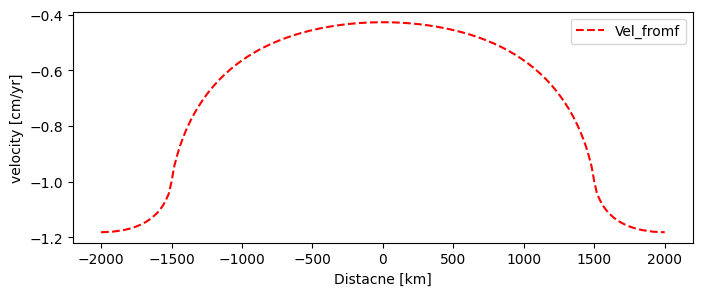

In [9]:
type_ = 1
iyr = dct(f[:,3],type=type_,n=kkt+1)*vscaling/2*1.5

# Topo in nox
fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
ax1.set(xlabel='Distacne [km]', ylabel='velocity [cm/yr]') 
#ax1.set_xlim([0,1500])
#ax1.plot(xcoordi/1000,topo_v0[:],c="k",label="Vel_origin")
ax1.plot(xcoordi/1000,iyr,"r--",label="Vel_fromf")
ax1.legend(loc='upper right')

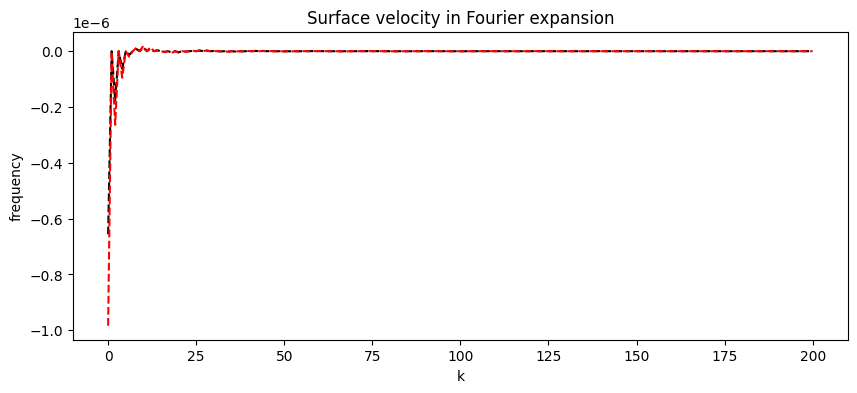

In [10]:
type_ = 1
yr2 = idct(np.float128(iyr/vscaling)*2,type=type_,n=kkt+1)

fig, ax1 = plt.subplots(nrows=1, figsize=(10,4))
ax1.set(xlabel='k', ylabel='frequency',title="Surface velocity in Fourier expansion") 
ax1.plot(f[:,3],"k--",label="Vel")
#ax1.plot(yr,"r-",label="Vel")
ax1.plot(yr2,"r--",label="Vel")

In [11]:
# type_ = 3
# f_x = dct(np.float128(f[:,3]),type=type_,n=nox)
# fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
# ax1.set(xlabel='Distacne [km]', ylabel='velocity [cm/yr]') 
# #ax1.plot(xcoordi/1000,f_x*vscaling,c="k",label="Vel")
# ax1.plot(xcoordi/1000,f_x*vscaling,c="k",label="Vel")

In [12]:
# # Lcs = 1000 # [km]
# # Vcs = 3/100  # [m/yr] 

# # topo_v0 = mp.matrix(nox, 1)
# # for ij in range(nox):
# #     if xcoordi[ij]<= Lcs*1000/2:
# #         topo_v0[ij] = -(xcoordi[ij]-(Lcs*1000/2))/(Lcs*1000/2)*Vcs/2
# #     else:
# #         topo_v0[ij] = 0.

# # from scipy.fft import dct, idct
# # type_ = 1
# # yr = idct(np.float128(topo_v0/vscaling)*2,type=type_,n=nox) 
# # ff_new = yr[1:kkt+1]



# Lcs = 1000*1000/2 # [m]
# mid = boxl/2*1000 # [m]
# Vcs = 3/100  # [m/yr] 

# topo_v0 = mp.matrix(nox, 1)
# for ij in range(nox):
#     if xcoordi[ij]<= (mid-Lcs/2):
#         topo_v0[ij] = Vcs 
#     elif xcoordi[ij]<= (mid+Lcs/2):
#         topo_v0[ij] = -(xcoordi[ij]-(mid+Lcs/2))/(Lcs)*Vcs   
#     else:
#         topo_v0[ij] = 0.
# type_ = 1
# yr = idct(np.float128(topo_v0/vscaling)*2,type=type_,n=nox) 
# ff_new = yr[1:kkt+1]

# # Topo in nox
# fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
# ax1.set(xlabel='Distacne [km]', ylabel='velocity [cm/yr]') 
# #ax1.set_xlim([0,1500])
# ax1.plot(xcoordi/1000,topo_v0[:]*100,c="k",label="Vel")


# fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
# ax1.plot(ff_new,"r--",label="Vel")

In [13]:
# topo_v0_new = mp.matrix(nox,1)
# for k in range(1, kkt+1):
#     for ij in range(nox):
#         topo_v0_new[ij] += ff_new[k-1] * acosine[ij, k-1] * vscaling
        
# # Topo in nox
# fig, ax1 = plt.subplots(nrows=1, figsize=(8,3))
# ax1.set(xlabel='Distacne [km]', ylabel='velocity [cm/yr]') 
# #ax1.set_xlim([0,1500])
# ax1.plot(xcoordi/1000,topo_v0[:]*100,c="k",label="Vel_origin")
# ax1.plot(xcoordi/1000,topo_v0_new[:]*100,"r--",label="Vel_fromff")
# ax1.legend(loc='upper right')

In [14]:
def form_alphas(tau,ak,am):
    caa = mp.matrix(nii,1)
    cbb = mp.matrix(nii,1)
    temp = mp.matrix(nii,1)
    temp1 = mp.matrix(nii,1)
    temp2 = mp.matrix(nii,1)
    taui = tau 
    if taui[1] == taui[0]:
        if taui[1] == taui[2]:
            caa[0] = 1.0
            caa[1] = tau[1]
            icaa = 1
            if tau[1]!= 0.0:
                icaa=2
        elif taui[1] != taui[2]:
            temp2[0] = 1.0
            temp2[1] = tau[1]
            itemp2 = 1
            temp[0] = 1.0
            temp[1] = tau[2]
            itemp = 1
            if taui[1]!= 0.0: itemp2 = 2
            if taui[2]!= 0.0: itemp = 2
            caa,icaa = multip_s(temp2,itemp2,temp,itemp)
    elif taui[1]!= taui[0]:
        temp1[0] = 1.0
        temp1[1] = tau[0]
        itemp1 = 1
        if taui[0]!= 0.0: itemp1 = 2
        if taui[1] == taui[2]:
            temp[0] = 1.0
            temp[1] = tau[1]
            itemp = 1
            if taui[1] != 0.0:itemp = 2
            caa,icaa = multip_s(temp,itemp,temp1,itemp1)
        elif taui[1]!= taui[2]: 
            temp[0] = 1.0
            temp[1] = tau[1]
            itemp = 1
            if taui[1]!= 0.0:itemp = 2
            temp2,itemp2 = multip_s(temp,itemp,temp1,itemp1)
            temp[0] = 1.0
            temp[1] = tau[2]
            itemp = 1
            if taui[2]!=0.0:itemp = 2
            caa,icaa = multip_s(temp2,itemp2,temp,itemp)
            
    temp1[0] = 1/mp.exp(ak*am)
    for k in range(icaa):
        caa[k] = temp1[0]*caa[k]
        
    if taui[3] == taui[4]:
        cbb[0] = 1.0
        cbb[1] = tau[3]
        icbb = 1
        if tau[3]!= 0.0: icbb=2
    else:
        temp[0] = 1.0
        temp[1] = tau[3]
        itemp = 1
        if taui[3]!=0: itemp = 2
        temp1[0] = 1.0
        temp1[1] = tau[4]
        itemp1 = 1
        if taui[4]!=0:itemp1 = 2
        cbb,icbb = multip_s (temp,itemp,temp1,itemp1)
        
    temp1[0] = 1/mp.exp(ak*(1-am))
    for k in range(icbb):
        cbb[k] = temp1[0]*cbb[k]
    return caa,icaa,cbb,icbb

### Subroutine

In [15]:
nii = int(20) # for aa(4,4,nii) amd caa(nii), nii=60 in fortran codes # or just simplied to 3*nlayer?

# generate propagator matrix  
def prop1(visc, tau, ak, xx0, xx1):
    a = mp.matrix(4, 4, nii)
    ia = np.ones((4,4),dtype=int)

    tau1 = tau
    tt = ak * (xx1 - xx0)

    a[0, 0, 0] = cos1(tt) - tt * sin1(tt)
    a[0, 0, 1] = (cos1(tt) - tt * sin1(tt)) * tau
    if tau1 != 0.0:
        ia[0, 0] = 2

    a[0, 1, 0] = -tt * cos1(tt)
    a[0, 1, 1] = -tt * cos1(tt) * tau
    if tau1 != 0.0:
        ia[0, 1] = 2

    a[0, 2, 0] = (sin1(tt) - tt * cos1(tt)) / visc
    a[0, 2, 1] = 2.0 * tau * (sin1(tt) - tt * cos1(tt)) / visc
    a[0, 2, 2] = tau * tau * (sin1(tt) - tt * cos1(tt)) / visc
    if tau1 != 0.0:
        ia[0, 2] = 3

    a[0, 3, 0] = -tt * sin1(tt) / visc
    a[0, 3, 1] = -2.0 * tau * tt * sin1(tt) / visc
    a[0, 3, 2] = -tau * tau * tt * sin1(tt) / visc
    if tau1 != 0.0:
        ia[0, 3] = 3

    a[1, 0, 0] = tt * cos1(tt)
    a[1, 0, 1] = tau * tt * cos1(tt)
    if tau1 != 0.0:
        ia[1, 0] = 2

    a[1, 1, 0] = cos1(tt) + tt * sin1(tt)
    a[1, 1, 1] = (cos1(tt) + tt * sin1(tt)) * tau
    if tau1 != 0.0:
        ia[1, 1] = 2

    a[1, 2, 0] = tt * sin1(tt) / visc
    a[1, 2, 1] = 2 * tau * tt * sin1(tt) / visc
    a[1, 2, 2] = tau * tau * tt * sin1(tt) / visc
    if tau1 != 0.0:
        ia[1, 2] = 3

    a[1, 3, 0] = (sin1(tt) + tt * cos1(tt)) / visc
    a[1, 3, 1] = 2 * tau * (sin1(tt) + tt * cos1(tt)) / visc
    a[1, 3, 2] = tau * tau * (sin1(tt) + tt * cos1(tt)) / visc
    if tau1 != 0.0:
        ia[1, 3] = 3

    a[2, 0, 0] = (sin1(tt) - tt * cos1(tt)) * visc
    ia[2, 0] = 1

    a[2, 1, 0] = -tt * sin1(tt) * visc
    ia[2, 1] = 1

    a[2, 2, 0] = cos1(tt) - tt * sin1(tt)
    a[2, 2, 1] = (cos1(tt) - tt * sin1(tt)) * tau
    if tau1 != 0.0:
        ia[2, 2] = 2

    a[2, 3, 0] = -tt * cos1(tt)
    a[2, 3, 1] = -tt * cos1(tt) * tau
    if tau1 != 0.0:
        ia[2, 3] = 2

    a[3, 0, 0] = tt * sin1(tt) * visc
    ia[3, 0] = 1

    a[3, 1, 0] = (sin1(tt) + tt *  cos1(tt)) * visc
    ia[3, 1] = 1

    a[3, 2, 0] = tt * cos1(tt)
    a[3, 2, 1] = tt * cos1(tt) * tau
    if tau1 != 0.0:
        ia[3, 2] = 2

    a[3, 3, 0] = cos1(tt) + tt * sin1(tt)
    a[3, 3, 1] = (cos1(tt) + tt * sin1(tt)) * tau
    if tau1 != 0.0:
        ia[3, 3] = 2
    return a,ia

def cos1(x):
    one = 1.0
    two = 2.0
    return (one + mp.exp(-two * x)) / two

def sin1(x):
    one = 1.0
    two = 2.0
    return (one - mp.exp(-two * x)) / two
    
# functions for matrix calculation    
def get_unit_matrix():
    aa = mp.matrix(4, 4, nii)
    iaa = np.ones((4,4),dtype=int)
    for i in range(4):
        for j in range(4):
            if i == j:
                aa[i, j, 0] = 1
    return aa, iaa

# (p2, ip2, aa, iaa)
def matrix_multi_mat(ain1, iain1, ain2, iain2):
    out1 = mp.matrix(4, 4, nii)
    iout1 = np.ones((4,4),dtype=int)
    out = mp.matrix(4, 4, nii)
    iout = np.ones((4,4),dtype=int)
    
    for i in range(4):
        for j in range(4):
            iout1[i,j]=1
            for k in range(4):
                iout1[i,j] = max(iout1[i,j], iain1[i, k] + iain2[k, j] - 1)
                for ii in range(iain1[i, k]):
                    for jj in range(iain2[k, j]):
                        kk = ii + jj   
                        out1[i, j, kk] += ain1[i, k, ii] * ain2[k, j, jj]
                        
    for i in range(4):
        for j in range(4):
            outtt = out1[i, j, iout1[i, j]-1]
            if outtt == 0.0:
                iout1[i, j] -= 1
            iout[i, j] = int(iout1[i, j])
            for k in range(iout1[i, j]):
                out[i, j, k] = out1[i, j, k]
    iout[iout< 1] = 1
    return out,iout    

def multip_s(temp, itemp,c, ic):
    out1 = mp.matrix(nii,1)
    out = mp.matrix(nii,1)
    iout1 = ic + itemp - 1
    for i in range(ic):
        for j in range(itemp):
            k = i + j
            out1[k] += c[i] * temp[j]
            
    iout = iout1
    for k in range(iout):
        out[k] = out1[k]
    return out, iout

def add_s(c, ic, temp, itemp):
    out = mp.matrix(nii,1)
    for k in range(nii):
        out[k] = 0.0
        if k >= ic:
            c[k] = 0.0
        if k >= itemp:
            temp[k] = 0.0
    iout = max(ic, itemp)
    for i in range(iout):
        out[i] = c[i] + temp[i]
    return out, iout

def add_ss(out, iout,oin, ioin, i):
    for k in range(nii):
        if k >= iout:
            out[k] = 0.0
        if k >= ioin:
            oin[k] = 0.0
    iout = max(iout, ioin)

    for k in range(iout):
        if i == 1:
            out[k] = out[k] + oin[k]
        else:
            out[k] = out[k] - oin[k]
    return out, iout
        
# system equations

# form the 4x4 matrix of the eigen-equations
def form_dett(aa,iaa,bb,ibb,cc,icc,ak,r0,delta_rho,qqq,qqq1,iv_or_t):
    dett = mp.matrix(4,4,nii)
    idett = np.ones((4,4),dtype=int)
    
    # for the first two third columns
    for k in range(nii):
        if k == 0:
            down = 0.0
            j = k
        else:
            down = 1.0
            j = k - 1
        dett[0,0,k] = down * aa[0,0,j] + aa[0,2,k] * qqq / (2.0 * ak)
        dett[1,0,k] = down * bb[0,0,j] + bb[0,2,k] * qqq / (2.0 * ak)
        dett[2,0,k] = down * bb[2,0,j] + bb[2,2,k] * qqq / (2.0 * ak)
        dett[0,1,k] = aa[0,1,k]
        dett[1,1,k] = bb[0,1,k]
        dett[2,1,k] = bb[2,1,k]
        
        if iv_or_t == 1:
            dett[3,0,k+1] = down * bb[1,0,j] + bb[1,2,k] * qqq / (2.0 * ak)
            dett[3,1,k+1] = bb[1,1,k]
        else:
            dett[3,0,k+1] = down * bb[3,0,j] + bb[3,2,k] * qqq / (2.0 * ak)
            dett[3,1,k+1] = bb[3,1,k]
        
        
    idett[0,0] = max(iaa[0,0] + 1, iaa[0,2])
    idett[1,0] = max(ibb[0,0] + 1, ibb[0,2])
    idett[2,0] = max(ibb[2,0] + 1, ibb[2,2])
    idett[0,1] = iaa[0,1]
    idett[1,1] = ibb[0,1]
    idett[2,1] = ibb[2,1]
    idett[0,2] = 2
    idett[1,2] = icc[0,2]
    idett[2,2] = icc[2,2]
    
    if iv_or_t == 1:
        idett[3,0] = max(ibb[1,0] + 1, ibb[1,2])+1
        idett[3,1] = ibb[1,1]+1
        idett[3,2] = icc[1,2]+1
    else:
        idett[3,0] = max(ibb[3,0] + 1, ibb[3,2])+1
        idett[3,1] = ibb[3,1]+1
        idett[3,2] = icc[3,2]+1

    dett[0,2,0] = 0.0
    dett[0,2,1] = -1.0
    for k in range(nii):
        dett[1,2,k] = cc[0,2,k] * r0 * delta_rho / (2.0 * ak)
        dett[2,2,k] = cc[2,2,k] * r0 * delta_rho / (2.0 * ak)
        if iv_or_t == 1:
            dett[3,2,k+1] = cc[1,2,k] * r0 * delta_rho / (2.0 * ak)
        else:
            dett[3,2,k+1] = cc[3,2,k] * r0 * delta_rho / (2.0 * ak)

    # For the last column
    idett[1,3] = 2
    dett[1,3,0] = 0.0
    dett[1,3,1] = -1.0

    idett[2,3] = 1
    dett[2,3,0] = -qqq1 / (2.0 * ak)

    return dett, idett
 
# form constants of the eigen-equations
def form_coeff(dett,idett):
    temp = mp.matrix(3,3,nii)
    itemp = np.ones((3,3),dtype=int)
    temp1 = mp.matrix(nii,1)
    # Co-determinant of (2,4)
    for j in range(3):
        for k in range(idett[0,j]):
            temp[0,j,k] = dett[0,j,k]
        itemp[0,j] = idett[0,j]
        for k in range(idett[2,j]):
            temp[1,j,k] = dett[2,j,k]
        itemp[1,j] = idett[2,j]
        for k in range(idett[3,j]):
            temp[2,j,k] = dett[3,j,k]
        itemp[2,j] = idett[3,j]
    out,iout = determinant3_s(temp,itemp)
    for k in range(idett[1,3]):
        temp1[k] = dett[1,3,k]
    itemp1 = idett[1,3]
    out1,iout1 = multip_s(out,iout,temp1,itemp1)

    # Co-determinant of (3,4)
    for j in range(3):
        for k in range(idett[0,j]):
            temp[0,j,k] = dett[0,j,k]
        itemp[0,j] = idett[0,j]

        for k in range(idett[1,j]):
            temp[1,j,k] = dett[1,j,k]
        itemp[1,j] = idett[1,j]

        for k in range(idett[3,j]):
            temp[2,j,k] = dett[3,j,k]
        itemp[2,j] = idett[3,j]

    out,iout = determinant3_s(temp,itemp)
    for k in range(idett[2,3]):
        temp1[k] = -dett[2,3,k]
    itemp1 = idett[2,3]
    out2,iout2 = multip_s(out,iout,temp1,itemp1)
    co,ico = add_s(out1,iout1,out2,iout2)
    return co,ico
 
def determinant3_s(tin,itin):
    a11 = mp.matrix(nii,1)
    a12 = mp.matrix(nii,1)
    a13 = mp.matrix(nii,1)
    a21 = mp.matrix(nii,1)
    a22 = mp.matrix(nii,1)
    a23 = mp.matrix(nii,1)
    a31 = mp.matrix(nii,1)
    a32 = mp.matrix(nii,1)
    a33 = mp.matrix(nii,1)
    for k in range(itin[0, 0]):
        a11[k]=tin[0, 0, k]
    for k in range(itin[0, 1]):
        a12[k]=tin[0, 1, k]
    for k in range(itin[0, 2]):
        a13[k]=tin[0, 2, k]
    for k in range(itin[1, 0]):
        a21[k]=tin[1, 0, k]
    for k in range(itin[1, 1]):
        a22[k]=tin[1, 1, k]
    for k in range(itin[1, 2]):
        a23[k]=tin[1, 2, k]
    for k in range(itin[2, 0]):
        a31[k]=tin[2, 0, k]
    for k in range(itin[2, 1]):
        a32[k]=tin[2, 1, k]
    for k in range(itin[2, 2]):
        a33[k]=tin[2, 2, k]

    temp, itemp = multip_s(a11, itin[0,0], a22, itin[1,1])
    out1, iout1 = multip_s(temp, itemp, a33, itin[2,2])

    temp, itemp = multip_s(a21, itin[1,0], a32, itin[2,1])
    out2, iout2 = multip_s(temp, itemp, a13, itin[0,2])

    temp, itemp = multip_s(a12, itin[0,1], a23, itin[1,2])
    out3, iout3 = multip_s(temp, itemp, a31, itin[2,0])

    temp, itemp = multip_s(a13, itin[0,2], a22, itin[1,1])
    out4, iout4 = multip_s(temp, itemp, a31, itin[2,0])

    temp, itemp = multip_s(a11, itin[0,0], a32, itin[2,1])
    out5, iout5 = multip_s(temp, itemp, a23, itin[1,2])

    temp, itemp = multip_s(a33, itin[2,2], a12, itin[0,1])
    out6, iout6 = multip_s(temp, itemp, a21, itin[1,0])
    
    out, iout = add_s(out1, iout1, out2, iout2)
    out, iout = add_ss(out, iout,out3, iout3, 1)
    out, iout = add_ss(out, iout,out4, iout4, 0)
    out, iout = add_ss(out, iout,out5, iout5, 0)
    out, iout = add_ss(out, iout,out6, iout6, 0)

    return out, iout
    
def eigenvalues(co,ico,dett,idett,f4i,mantle_s):
    EPS = 1e-7
    #its = 10000
    zero = 0.0
    
    coi = co[:ico]
    
    ac = mp.matrix(int(ico),1)
    ad = mp.matrix(int(ico),1)
    
    if f4i != 0 :
        for i in range(1,ico):
            ac[i-1] = mp.mpc(co[i], zero)
            ad[i-1] = mp.mpc(co[i], zero)
        m = int(ico - 2)
    else:
        for i in range(ico):
            ac[i] = mp.mpc(co[i], zero)
            ad[i] = mp.mpc(co[i], zero)
        m = int(ico - 1)
    
    xxc = mp.matrix(int(ico - 1),1)
    xx = mp.matrix(int(ico - 1),1)

    for j in range(m-1, -1, -1):
        x = mp.mpc(zero,zero)
        x = laguer(ad, j+1,x)
        ximag = abs(x.imag)
        xreal = abs(x.real)
        if ximag <= xreal * EPS:
            x = mp.mpc(x.real, zero)
        xxc[j] = x
        b = ad[j+1]
        for jj in range(j, -1, -1):
            c = ad[jj]
            ad[jj] = b
            b = x * b + c
        
    for j in range(m):
        xxc[j] = laguer(ac, m, xxc[j]) 
        
#     dettf = mp.matrix(4,4,m)   
#     xx,dettf = get_dettf(xxc, m, dett,idett,f4i,mantle_s) 
    dettf = mp.matrix(4,4,int(ico - 1))
    for ie in range(m):
        xx[ie] = xxc[ie].real
        dettf = get_dettf(xx[ie],dett,idett,dettf,ie)
        #dettf[:,:,ie] = dettf_ie
        
    if f4i !=0:
        ie = int(ico-1)
        xx[ie-1] = 0.0
        dettf = get_dettf(0.0,dett,idett,dettf,ie-1)
        #dettf[:,:,ie-1] = dettf_ie
    
    if mantle_s ==1:
        #ico = ico+1
        ie = int(ico)
        xx[ie-1] = 0.0
        ddettf = get_dettf(0.0,dett,idett,dettf,ie-1)
        #dettf[:,:,ie-1] = dettf_ie
    return xx,dettf

def laguer(a, m,x):
    maxit = 8 * 100
    EPSS = 1e-26 
    zero = 0.0

    for iter_ in range(maxit):
        its = iter_
        b = a[m]
        err = abs(b)
        d = mp.mpc(zero,zero)
        f = mp.mpc(zero,zero)
        abx = abs(x)
        for j in range(m-1, -1, -1):
            f = x * f + d
            d = x * d + b
            b = x * b + a[j]
            err = abs(b) + abx * err
        err *= EPSS
        errt = abs(b)
        if errt > err:
            g = d / b
            g2 = g * g
            h = g2 - 2.0 * f / b
            sq = mp.sqrt((m - 1.0) * (m * h - g2))
            gp = g + sq
            gm = g - sq
            abp = abs(gp)
            abm = abs(gm)
            if abp < abm:
                gp = gm
            if max(abp, abm) > 0.0:
                dx = m / gp
            else:
                temp = iter_+1.0
                dx = mp.exp(mp.log(1.0 + abx)) * mp.mpc(mp.cos(temp),mp.sin(temp))
            x1 = x - dx
            x = x1
        else:
            break
    return x 

def get_dettf0(xxc,m,dett,idett,f4i,mantle_s):
    dettf = mp.matrix(4,4,m)
    x = mp.matrix(m,1)
    for ie in range(m):
        x[ie] = xxc[ie].real
        temp = mp.matrix(nii,1)
        for i in range(4):
            for j in range(4):
                for k in range(idett[i,j]):
                    temp[k] = dett[i,j,k]
                dettf[i,j,ie] = evalue(temp, idett[i,j], x[ie])    
    return x,dettf   

def get_dettf(xx,dett,idett,dettf,ie):
    temp = mp.matrix(nii,1)
    for i in range(4):
        for j in range(4):
            for k in range(idett[i,j]):
                temp[k] = dett[i,j,k]
            dettf[i,j,ie] = evalue(temp, idett[i,j], xx)    
    return dettf 
    
def evalue(caa,icaa,x):
    value = caa[0]
    for i in range(2,icaa+1):
        value += caa[i-1]*(x**(i-1))
    return value
        
def eigenfunctions(xx,ico,n,dettf,caa,icaa,cbb,icbb,f,co):
    eigenf = mp.matrix(int(ico-1),1) 
    if n == 1:
        for i in range(ico-1):
            eigenf[i] = residue1(xx[i], i,dettf,caa,icaa,cbb,icbb,f,co,ico)
    elif n == 2:
        for i in range(ico-1):
            eigenf[i] = residue2(xx[i], i,dettf,caa,icaa,cbb,icbb,f,co,ico)
    elif n == 3:
        for i in range(ico-1):
            eigenf[i] = residue3(xx[i], i,dettf,caa,icaa,cbb,icbb,f,co,ico)
    elif n == 4:
        for i in range(ico-1):
            eigenf[i] = residue4(xx[i], i,dettf,caa,icaa,cbb,icbb,f,co,ico)
    return eigenf  
    
# eigenfunction for surface topography 
def residue1(x, ie,dettf,caa,icaa,cbb,icbb,f,co,ico):
    upm = mp.matrix(4,4)

    upm[0,0] = dettf[0,0,ie]
    upm[1,0] = dettf[1,0,ie]
    upm[2,0] = dettf[2,0,ie]
    upm[3,0] = dettf[3,0,ie]
    upm[0,1] = dettf[0,1,ie]
    upm[1,1] = dettf[1,1,ie]
    upm[2,1] = dettf[2,1,ie]
    upm[3,1] = dettf[3,1,ie]
    upm[0,2] = dettf[0,2,ie]
    upm[1,2] = dettf[1,2,ie]
    upm[2,2] = dettf[2,2,ie]
    upm[3,2] = dettf[3,2,ie]
    
#     upm[:,0] = dettf[:,0,ie]
#     upm[:,1] = dettf[:,1,ie]
#     upm[:,2] = dettf[:,2,ie]

    const1 = evalue(cbb, icbb, x)

    if mantle_s == 0:
        upm[0,3] = -f[0] / const1
        upm[1,3] = -f[1]
        upm[2,3] = 0.0
        upm[3,3] = f[3]
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i] * (x ** (i - 1))
            
        #print('residue1, ie:',ie)    
        #write_matrix(upm)
        
    elif mantle_s == 1:
        const2 = r0*dTemp/(2.0*ak*const1*evalue(caa,icaa,x))
        for k in range(idd[0,2]):
            temp[k] = dd[0,2,k]
        temp1 = evalue(temp,idd[0,2],x)
        upm[0,3] = -f[0]*x/const1- temp1*const2

        for k in range(iee[0,2]):
            temp[k] = ee[0,2,k]
        temp1 = evalue(temp,iee[0,2],x)
        upm[1,3] = -f[1]*x -temp1*const2

        for k in range(iee[2,2]):
            temp[k] = ee[2,2,k]
        temp1 = evalue(temp,iee[2,2],x)
        upm[2,3] = -temp1*const2

        for k in range(iee(3,2)):
            temp[k] = ee[3,2,k]
        temp1 = evalue(temp,iee[3,2],x)
        upm[3,3] = -temp1*const2  
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i-1] * (x ** (i - 1))       
        
    residue1 = up / down
    return residue1

# moho topography 
def residue2(x, ie,dettf,caa,icaa,cbb,icbb,f,co,ico):
    upm = mp.matrix(4,4)

    upm[0,0] = dettf[0,0,ie]
    upm[1,0] = dettf[1,0,ie]
    upm[2,0] = dettf[2,0,ie]
    upm[3,0] = dettf[3,0,ie]
    upm[0,1] = dettf[0,1,ie]
    upm[1,1] = dettf[1,1,ie]
    upm[2,1] = dettf[2,1,ie]
    upm[3,1] = dettf[3,1,ie]
    upm[0,3] = dettf[0,3,ie]
    upm[1,3] = dettf[1,3,ie]
    upm[2,3] = dettf[2,3,ie]
    upm[3,3] = dettf[3,3,ie]

#     upm[:,0] = dettf[:,0,ie]
#     upm[:,1] = dettf[:,1,ie]
#     upm[:,3] = dettf[:,3,ie]
    
    const1 = evalue(cbb, icbb, x)
    
    if mantle_s == 0:
        upm[0,2] = -f[0] 
        upm[1,2] = -f[1] * const1
        upm[2,2] = 0.0
        upm[3,2] = f[3] * const1
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i] * (x ** (i - 1))
         
        #print('residue2, ie:',ie)    
        #write_matrix(upm)
        
    elif mantle_s == 1:
        const2 = r0*dTemp/(2.0*ak*evalue(caa,icaa,x))
        for k in range(idd[0,2]):
            temp[k] = dd[0,2,k]
        temp1 = evalue(temp,idd[0,2],x)
        upm[0,2] = -f[0]*x- temp1*const2

        for k in range(iee[0,2]):
            temp[k] = ee[0,2,k]
        temp1 = evalue(temp,iee[0,2],x)
        upm[1,2] = -f[1]*x*const1 -temp1*const2

        for k in range(iee[2,2]):
            temp[k] = ee[2,2,k]
        temp1 = evalue(temp,iee[2,2],x)
        upm[2,2] = -temp1*const2

        for k in range(iee(3,2)):
            temp[k] = ee[3,2,k]
        temp1 = evalue(temp,iee[3,2],x)
        upm[3,2] = -temp1*const2  
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i-1] * (x ** (i - 1))  

    residue2 = up / down
    return residue2

# bottom topography
def residue3(x, ie,dettf,caa,icaa,cbb,icbb,f,co,ico):
    upm = mp.matrix(4,4)

    upm[0,1] = dettf[0,1,ie]
    upm[1,1] = dettf[1,1,ie]
    upm[2,1] = dettf[2,1,ie]
    upm[3,1] = dettf[3,1,ie]
    upm[0,2] = dettf[0,2,ie]
    upm[1,2] = dettf[1,2,ie]
    upm[2,2] = dettf[2,2,ie]
    upm[3,2] = dettf[3,2,ie]
    upm[0,3] = dettf[0,3,ie]
    upm[1,3] = dettf[1,3,ie]
    upm[2,3] = dettf[2,3,ie]
    upm[3,3] = dettf[3,3,ie]
    
#     upm[:,1] = dettf[:,1,ie]
#     upm[:,2] = dettf[:,2,ie]
#     upm[:,3] = dettf[:,3,ie]

    const1 = evalue(caa, icaa, x)
    const2 = evalue(cbb, icbb, x)*const1
    
    if mantle_s == 0:
        upm[0,0] = -f[0] * const1 
        upm[1,0] = -f[1] * const2
        upm[2,0] = 0.0
        upm[3,0] = f[3] * const2
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i] * (x ** (i - 1))
        
    elif mantle_s == 1:
        for k in range(idd[0,2]):
            temp[k] = dd[0,2,k]
        temp1 = evalue(temp,idd[0,2],x)
        upm[0,0] = -f[0]*x*const1-temp1*r0*dTemp/(2.0*ak)

        for k in range(iee[0,2]):
            temp[k] = ee[0,2,k]
        temp1 = evalue(temp,iee[0,2],x)
        upm[1,0] = -f[1]*x*const2-temp1*r0*dTemp/(2.0*ak)

        for k in range(iee[2,2]):
            temp[k] = ee[2,2,k]
        temp1 = evalue(temp,iee[2,2],x)
        upm[2,0] = -temp1*r0*dTemp/(2.0*ak)

        for k in range(iee(3,2)):
            temp[k] = ee[3,2,k]
        temp1 = evalue(temp,iee[3,2],x)
        upm[3,0] = -temp1*r0*dTemp/(2.0*ak) 
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i-1] * (x ** (i - 1))  

    residue3 = up / down
    return residue3

# bottom horizontal velocsity
def residue4(x, ie, dettf,caa,icaa,cbb,icbb,f,co,ico):
    upm = mp.matrix(4,4)

    upm[0,0] = dettf[0,0,ie]
    upm[1,0] = dettf[1,0,ie]
    upm[2,0] = dettf[2,0,ie]
    upm[3,0] = dettf[3,0,ie]
    upm[0,2] = dettf[0,2,ie]
    upm[1,2] = dettf[1,2,ie]
    upm[2,2] = dettf[2,2,ie]
    upm[3,2] = dettf[3,2,ie]
    upm[0,3] = dettf[0,3,ie]
    upm[1,3] = dettf[1,3,ie]
    upm[2,3] = dettf[2,3,ie]
    upm[3,3] = dettf[3,3,ie]    
#     upm[:,0] = dettf[:,0,ie]
#     upm[:,2] = dettf[:,2,ie]
#     upm[:,3] = dettf[:,3,ie]
    
    const1 = evalue(caa, icaa, x)
    const2 = evalue(cbb, icbb, x)*const1
    
    if mantle_s == 0:
        upm[0,1] = -f[0] * const1 
        upm[1,1] = -f[1] * const2
        upm[2,1] = 0.0
        upm[3,1] = f[3] * const2
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i] * (x ** (i - 1))
        
    elif mantle_s == 1:
        for k in range(idd[0,2]):
            temp[k] = dd[0,2,k]
        temp1 = evalue(temp,idd[0,2],x)
        upm[0,1] = -f[0]*x*const1-temp1*r0*dTemp/(2.0*ak)

        for k in range(iee[0,2]):
            temp[k] = ee[0,2,k]
        temp1 = evalue(temp,iee[0,2],x)
        upm[1,1] = -f[1]*x*const2-temp1*r0*dTemp/(2.0*ak)

        for k in range(iee[2,2]):
            temp[k] = ee[2,2,k]
        temp1 = evalue(temp,iee[2,2],x)
        upm[2,1] = -temp1*r0*dTemp/(2.0*ak)

        for k in range(iee(3,2)):
            temp[k] = ee[3,2,k]
        temp1 = evalue(temp,iee[3,2],x)
        upm[3,1] = -temp1*r0*dTemp/(2.0*ak) 
        
        up = determinant(upm)
        down = co[1]
        for i in range(2, ico):
            down += i * co[i-1] * (x ** (i - 1))  

    residue4 = up / down
    return residue4    

def determinant(a):
    return a[0, 0] * sub3(a[1, 1], a[1, 2], a[1, 3], a[2, 1], a[2, 2], a[2, 3], a[3, 1], a[3, 2], a[3, 3]) \
         - a[1, 0] * sub3(a[0, 1], a[0, 2], a[0, 3], a[2, 1], a[2, 2], a[2, 3], a[3, 1], a[3, 2], a[3, 3]) \
         + a[2, 0] * sub3(a[0, 1], a[0, 2], a[0, 3], a[1, 1], a[1, 2], a[1, 3], a[3, 1], a[3, 2], a[3, 3]) \
         - a[3, 0] * sub3(a[0, 1], a[0, 2], a[0, 3], a[1, 1], a[1, 2], a[1, 3], a[2, 1], a[2, 2], a[2, 3])
def sub3(a11, a12, a13, a21, a22, a23, a31, a32, a33):
    return a11 * a22 * a33 + a21 * a32 * a13 + a12 * a23 * a31 \
           - a13 * a22 * a31 - a11 * a32 * a23 - a33 * a12 * a21

### Main

In [16]:
def write_prop(p,ip):
    for i in range(4):
        for j in range(4):
            print("%.5e" % float(p[i,j,0]))
    print(ip)        
    print("\n")

In [17]:
def write_matrix(p):
    for i in range(4):
        for j in range(4):
            print("%.5e" % float(p[i,j]),end=' ')
        print("\n")
    print("\n")

In [18]:
nii = int(20) # for aa(4,4,nii) amd caa(nii), nii=60 in fortran codes 

# fname_save = case_name+'out_eigen_py.txt'
# fname_save_test = "out_test_py.txt"

#for k in range(1,3):
for k in range(1, kkt + 1):
    wavelength1= 2*boxl*1000/k
    wavelength = wavelength1/d
    ak = 2*pi/wavelength
    aki = 2*pi/wavelength1
    atempp = f[k-1,3]
    print("k=",k, "%.5e" %atempp)
    
    if iv_or_t==0:
        f[k-1,3] = f[k-1,3]/(2.0*ak) 
    
    if visc1i == visc2i:
        if visc2i == visc3i:
            aa,iaa =  prop1(visc1,tau[0],ak,zero,am)
        elif visc2i != visc3i:
            p1,ip1 = prop1(visc1,tau[0],ak,zero,al1)
            p3,ip3 = prop1(visc3,tau[2],ak,al1,am)
            aa,iaa = matrix_multi_mat(p3,ip3,p1,ip1)
    elif visc1i!=visc2i:
        p1,ip1 = prop1(visc1,tau[0],ak,zero,al)
        if visc2i == visc3i:
            p2,ip2 = prop1(visc2,tau[1],ak,al,am)
            aa,iaa = matrix_multi_mat(p2,ip2,p1,ip1)
        elif visc2i != visc3i:
            p2,ip2 = prop1(visc2,tau[1],ak,al,al1)
            p3,ip3 = prop1(visc3,tau[2],ak,al1,am)
            temp,itemp = matrix_multi_mat(p3,ip3,p2,ip2)
            aa,iaa = matrix_multi_mat(temp,itemp,p1,ip1)
        
    #write_prop(p1,ip1)
    
    if visc4i == visc5i:
        cc,icc = prop1(visc4,tau[3],ak,am,one)
    else:
        p4,ip4 = prop1(visc4,tau[3],ak,am,am1)
        p5,ip5 = prop1(visc5,tau[4],ak,am1,one)
        cc,icc = matrix_multi_mat(p5,ip5,p4,ip4)
   
    bb,ibb = matrix_multi_mat(cc,icc,aa,iaa)
    #for mantle buoyancy in the first layer, that is the bottom layer #
    if visc2i == visc3i:
        temp,itemp = prop1(visc2,tau[1],ak,al,am)
    elif visc2i != visc3i:
        p2,ip2 = prop1(visc2,tau[1],ak,al,al1)
        p3,ip3 = prop1(visc3,tau[2],ak,al1,am)
        temp,itemp = matrix_multi_mat(p3,ip3,p2,ip2)
    p1,ip1 = prop1(visc1,tau[0],ak,zs,al)
    dd,idd = matrix_multi_mat(temp,itemp,p1,ip1)
    ee,iee = matrix_multi_mat(cc,icc,dd,idd)    
    # -------------------------------------- #    
    
    caa,icaa,cbb,icbb = form_alphas(tau,ak,am)    
    dett,idett = form_dett(aa,iaa,bb,ibb,cc,icc,ak,r0,delta_rho,qqq,qqq1,iv_or_t)
    #write_prop(aa,iaa)
    #write_prop(dett,idett)
    co,ico = form_coeff(dett,idett)
    xx,dettf = eigenvalues(co,ico,dett,idett,f[k-1,3],mantle_s)
    
    #write_prop(dettf,idett)
    
#     with open(fname_save_test, 'a') as file:
#         formatted_row =[str("%.1d" %float(k)), str("%.5e" %float(wavelength1/1000))]
#         row_text = ' '.join(formatted_row)  
#         file.write(row_text + '\n')
#         file.write('\n')
    
#     with open(fname_save_test, 'a') as file:
#         for i in range(ico):
#             formatted_row = [str("%.1d" %float(i)), str("%.5e" %float(co[i]))]
#             row_text = ' '.join(formatted_row)  
#             file.write(row_text + '\n')
#             #print(str("%.1d" %float(i)), str("%.5e" %float(co[i])))
#         file.write('\n')
    
    xx1 = mp.matrix(int(ico),1)
    for i in range(ico-1):
        xx1[i] = xx[i]
        if xx1[i] != 0.0:
            xx1[i] = -1.0 / xx1[i] * tscaling / year
        else:
            xx1[i] = 1.0e98
        #print(i,xx1[i])
            
    t_surf = eigenfunctions(xx,ico,1,dettf,caa,icaa,cbb,icbb,f[k-1,:],co)
    t_moho = eigenfunctions(xx,ico,2,dettf,caa,icaa,cbb,icbb,f[k-1,:],co)
    t_botm = eigenfunctions(xx,ico,3,dettf,caa,icaa,cbb,icbb,f[k-1,:],co)
    v_botm = eigenfunctions(xx,ico,4,dettf,caa,icaa,cbb,icbb,f[k-1,:],co)

    
#     with open(fname_save, 'a') as file:
#         row = int(k),float(wavelength1/1000)
#         formatted_row = [f'{element:12.5e}' for element in row]  
#         row_text = ' '.join(formatted_row)  
#         file.write(row_text + '\n')
        
    for i in range(ico-1):
        t_surfi = t_surf[i] * d
        t_mohoi = t_moho[i] * d
        t_botmi = t_botm[i] * d
        v_botmi = v_botm[i] * vscaling
        
#         with open(fname_save, 'a') as file:
#             row = int(i),float(xx1[i]),float(t_surfi),float(t_mohoi),float(t_botmi),float(v_botmi)
#             formatted_row = [f'{element:12.5e}' for element in row]  
#             row_text = ' '.join(formatted_row)  
#             file.write(row_text + '\n')  
        #print(i,xx1[i],t_surfi,t_mohoi,t_botmi,v_botmi)
       
    #dt = np.log10(dti)/(ntime-1)
    deg = mp.matrix(ntime, kkt)
    topo_sk = mp.matrix(ntime, kkt)
    topo_mk = mp.matrix(ntime, kkt)
    velo_b = mp.matrix(ntime, nox)
    
    for i in range(ntime):
        #t = 10**(dt * (i - 1))
        t = ft[i]
        t = t * year / tscaling

        topo_suro = 0.0
        topo_moho = 0.0
        topo_botm = 0.0
        velo_botm = 0.0

        for j in range(ico-1):
            xyz = xx[j] * t
            if xyz > -1e4:
                topo_suro += t_surf[j] * mp.exp(xx[j] * t) * d
                topo_moho += t_moho[j] * mp.exp(xx[j] * t) * d
                topo_botm += t_botm[j] * mp.exp(xx[j] * t) * d
                velo_botm += v_botm[j] * mp.exp(xx[j] * t) * vscaling
                
        for ij in range(nox):
            topo_s[i,ij] += topo_suro* mp.cos(aki*xcoordi[ij])
            topo_m[i,ij] += topo_moho * mp.cos(aki*xcoordi[ij])
            topo_b[i,ij] += topo_botm * mp.cos(aki*xcoordi[ij])
            velo_b[i,ij] += velo_botm * mp.cos(aki*xcoordi[ij])
        
        if (topo_suro * (1.0-delta_rho)) == 0:
            deg[i,k-1] = 0.
        else:
            deg[i,k-1] = -((topo_moho * delta_rho) / (topo_suro * (1.0-delta_rho)))
        topo_sk[i,k-1] = topo_suro
        topo_mk[i,k-1] = topo_moho

k= 1 -6.55741e-07
k= 2 3.60525e-108
k= 3 -1.75900e-07
k= 4 5.40787e-108
k= 5 -6.33239e-08
k= 6 1.60233e-108
k= 7 -1.33825e-08
k= 8 4.55024e-108
k= 9 8.09556e-09
k= 10 -2.34341e-108
k= 11 1.30835e-08
k= 12 4.50656e-109
k= 13 9.36744e-09
k= 14 -6.43794e-109
k= 15 2.91440e-09
k= 16 4.28813e-109
k= 17 -2.26900e-09
k= 18 1.33528e-109
k= 19 -4.38531e-09
k= 20 -3.60525e-109
k= 21 -3.58979e-09
k= 22 -1.69337e-108
k= 23 -1.23959e-09
k= 24 4.30284e-109
k= 25 1.04918e-09
k= 26 -1.50219e-109
k= 27 2.17160e-09
k= 28 -4.72116e-109
k= 29 1.88240e-09
k= 30 3.85561e-109
k= 31 6.82352e-10
k= 32 2.14407e-109
k= 33 -6.02149e-10
k= 34 1.76728e-110
k= 35 -1.29232e-09
k= 36 1.58564e-109
k= 37 -1.15639e-09
k= 38 -1.58125e-110
k= 39 -4.31125e-10
k= 40 -7.44032e-109
k= 41 3.90090e-10
k= 42 3.64817e-109
k= 43 8.56191e-10
k= 44 -4.09687e-109
k= 45 7.81777e-10
k= 46 2.61250e-110
k= 47 2.96849e-10
k= 48 -1.48506e-110
k= 49 -2.73111e-10
k= 50 -3.36490e-109
k= 51 -6.08650e-10
k= 52 -8.37758e-110
k= 53 -5.63581e-10
k=

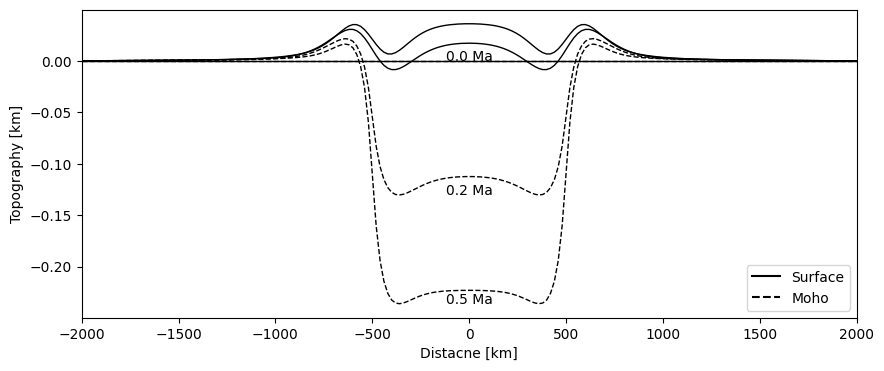

In [30]:
from matplotlib.lines import Line2D
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 
#ax1.set_ylim([-12,4])
ax1.set_xlim([-boxl/2,boxl/2])
#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
for i in range(ntime):
    Time = ft[i]/1e6
    ax1.plot(xcoordi/1000,topo_s[i,:]/1000, "k-",linewidth = 1)
    ax1.plot(xcoordi/1000,topo_m[i,:]/1000, "k--", linewidth = 1)
    plt.text(0,np.array(topo_m[i,:]).min()/1000, str("%.1f" %Time)+" Ma", ha='center',fontsize=10, color='k')

custom_legend = [Line2D([0], [0], color='k', linestyle='-', label='Surface'),
    Line2D([0], [0], color='k',linestyle='--', label='Moho'),
]    
legend = ax1.legend(handles=custom_legend, loc='lower right')
fig.savefig(case_name+"topo_and_moho")

In [20]:
# type_ = 1
# iyr = dct(f[:,3],type=type_,n=kkt+1)*vscaling/2



# figsize = (10,4)

# fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
# ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 

# #ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
# for i in range(ntime):
#     ax1.plot(xcoordi/1000,topo_s[i,:]/1000, "--", label = f"time = {ft[i]/1e6} Ma", linewidth = 1)
# #ax1.legend(loc='upper right')
# fig.savefig(case_name+"topo2")

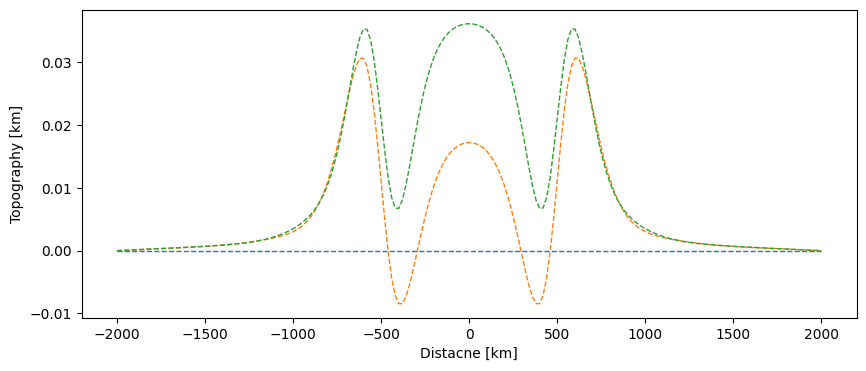

In [21]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]') 

#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
for i in range(ntime):
    ax1.plot(xcoordi/1000,topo_s[i,:]/1000, "--", label = f"time = {ft[i]/1e6} Ma", linewidth = 1)
#ax1.legend(loc='upper right')
fig.savefig(case_name+"topo")

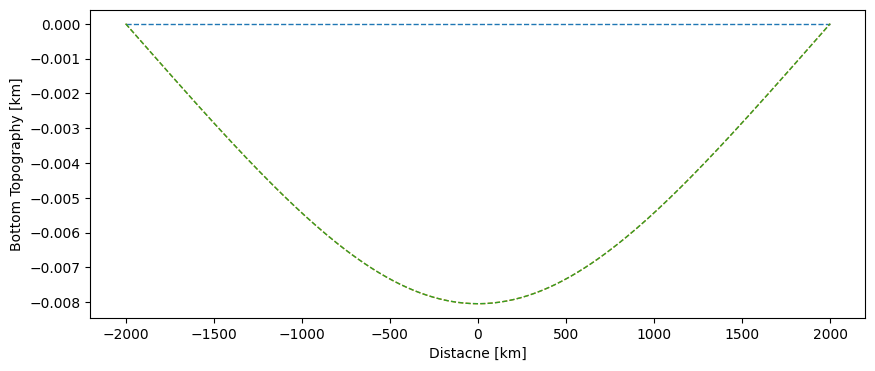

In [22]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Bottom Topography [km]') 

#ax1.plot(xcoordi/1000,topo_s[0,:]/1000, "-k", label = f"time = {ft[0]/1000.} Ka", linewidth = 1)
    
for i in range(ntime):
    ax1.plot(xcoordi/1000,topo_b[i,:]/1000, "--",label = f"time = {ft[i]/1e6} Ma", linewidth = 1)
#ax1.legend(loc='upper right')
fig.savefig(case_name+"bottom")

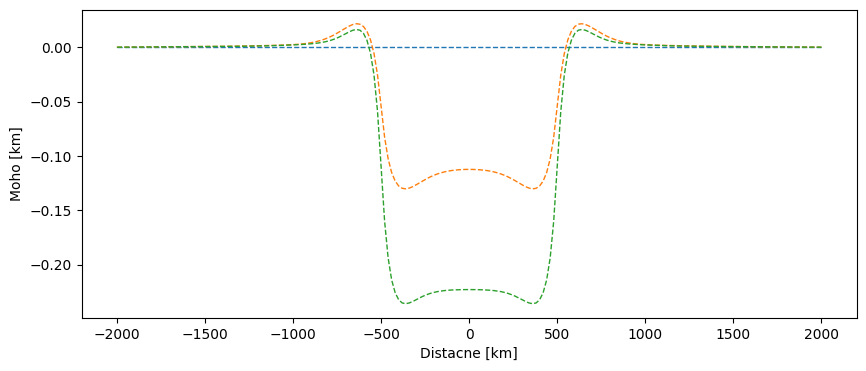

In [23]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Moho [km]') 

for i in range(ntime):
    ax1.plot(xcoordi/1000,topo_m[i,:]/1000, "--", label = f"time = {ft[i]/1e6} Ma", linewidth = 1)
#ax1.legend(loc='upper right')
fig.savefig(case_name+"moho")

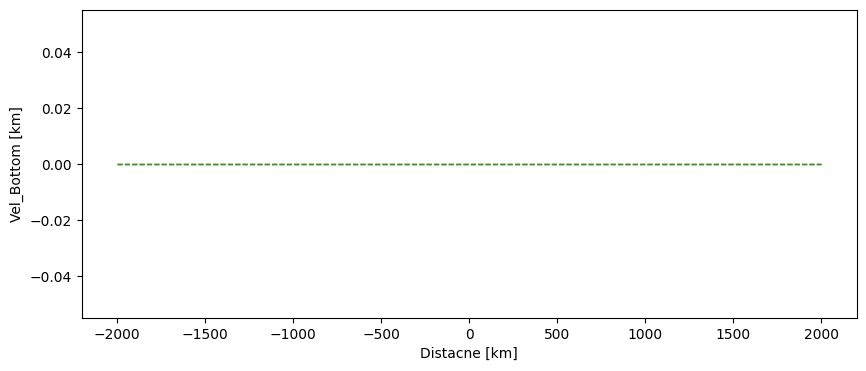

In [24]:
figsize = (10,4)

fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Vel_Bottom [km]') 

for i in range(ntime):
    ax1.plot(xcoordi/1000,velo_b[i,:], "--", label = f"time = {ft[i]/1e6} Ma", linewidth = 1)
#ax1.legend(loc='upper right')

In [25]:
fname_save = case_name+'topo_s_time.txt'
data = topo_s/1000

with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data[:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n')   
        
fname_save = case_name+'topo_m_time.txt'
data = topo_m/1000
with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data [:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n') 
        
fname_save = case_name+'topo_b_time.txt'
data = topo_b/1000
with open(fname_save, 'w') as file:
    for i in range(nox):
        row = np.float32(data [:,i])
        formatted_row = [f'{element:12.5e}' for element in row]  
        row_text = ' '.join(formatted_row)  
        file.write(row_text + '\n')   
        
fname_save = case_name+'topo_x.txt'
data = xcoordi/1000
with open(fname_save, 'w') as file:
    row = np.float32(data)
    formatted_row = [f'{element:12.5e}' for element in row]  
    row_text = ' '.join(formatted_row)  
    file.write(row_text + '\n')   

In [26]:
99=1

SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (3848930076.py, line 1)

### Outputs from source codes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fname = "Zhong2000_VE2D_Vel_fortran/out_time.case1"

f=open(fname,"r")
lines=f.readlines()

# number of time steps to work on
cntr = 0
len_arr = []
for l in lines:
    lstrip = l.split(sep = "\t")
    lstrip = lstrip[1:-1]
    if len(lstrip) == 2:
        cntr += 1 
    len_arr.append(len(lstrip))

len_arr = np.array(len_arr)
print(np.unique(len_arr))

In [ ]:
# split into the appropriate groups
time_dict = {}
topo_dict = {}
wave_dict = {}

time_idx = 0
data_idx = 0

topo_dummy = []
wave_dummy = []

for l in lines:
    lstrip = l.split(sep = "\t")
    lstrip = lstrip[1:-1]
    #print(lstrip)
    if len(lstrip) == 1:
        res = [eval(i) for i in lstrip]
        time_dict[time_idx] = res

        if time_idx > 0: # save the data from previous time step
            topo_df = pd.DataFrame(topo_dummy, columns = ["C1", "C2", "C3"])
            topo_dict[data_idx] = topo_df

            wave_df = pd.DataFrame(wave_dummy, columns = ["C1", "C2", "C3", "C4", "C5"])
            wave_dict[data_idx] = wave_df

            topo_dummy = []
            wave_dummy = []
            data_idx += 1
        
        time_idx += 1
    
    elif len(lstrip) == 3:
        res = [eval(i) for i in lstrip]
        topo_dummy.append(res)

    elif len(lstrip) == 5:
        res = [eval(i) for i in lstrip]
        wave_dummy.append(res)

# save the last one
topo_df = pd.DataFrame(topo_dummy, columns = ["C1", "C2", "C3"])
topo_dict[data_idx] = topo_df

wave_df = pd.DataFrame(wave_dummy, columns = ["C1", "C2", "C3", "C4", "C5"])
wave_dict[data_idx] = wave_df

In [ ]:
figsize = (10,4)
## 
fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]',title="Error") 
for i in range(len(topo_dict.keys())):
    topo_plot = topo_dict[i]
    time_plot = time_dict[i]

    ax1.plot(topo_plot["C1"], topo_plot["C2"]/1000.-topo_s[i,:]/1000.)
ax1.legend(loc='upper right')
fig.savefig(case_name+"topo_errors")

In [ ]:
figsize = (10,4)
## 
fig, ax1 = plt.subplots(nrows=1, figsize=figsize)
ax1.set(xlabel='Distacne [km]', ylabel='Topography [km]',title="Error") 
for i in range(len(topo_dict.keys())):
    topo_plot = topo_dict[i]
    time_plot = time_dict[i]

    ax1.plot(topo_plot["C1"], topo_plot["C3"]/1000.-topo_m[i,:]/1000.)
ax1.legend(loc='upper right')
fig.savefig(case_name+"moho_errors")